In [45]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr


In [46]:
# Read in file
column = ['objID','z','uMAG','rMAG','u-r','SVMPython']
df = pd.read_csv("dataset.tsv", sep='\t', header=None, names = column)
df.describe()


,objID,z,uMAG,rMAG,u-r,SVMPython
count,3.160310e+05,316031.000000,316031.000000,316031.000000,316031.000000,316031.000000
mean,1.237662e+18,0.063504,-18.495233,-20.575399,2.080166,0.558053
std,6.022167e+12,0.023058,1.034802,1.140994,0.610873,0.496619
min,1.237646e+18,0.003001,-26.045010,-25.957740,-3.803460,0.000000
25%,1.237658e+18,0.045979,-19.147785,-21.304710,1.660000,0.000000
50%,1.237662e+18,0.067202,-18.601710,-20.713750,2.158930,1.000000
75%,1.237665e+18,0.082217,-18.002450,-20.047520,2.500980,1.000000
max,1.237680e+18,0.100000,54.116670,-13.083160,78.125900,1.000000


In [47]:
# Selecting only 0.05 < z < 0.08 and spiral (late-type!) (SVMPython = 1), randomly sample 10,000 galaxies
df = df[(df['z']<0.08) & (df['z']>0.05) & (df['SVMPython']==1) & (df['uMAG']<50) & (df['rMAG']>-22)]
print("Dataframe size post-cut:",df.size)
df = df.sample(n=10000)

Dataframe size post-cut: 413856


In [48]:
max(df['uMAG'])

-10.514

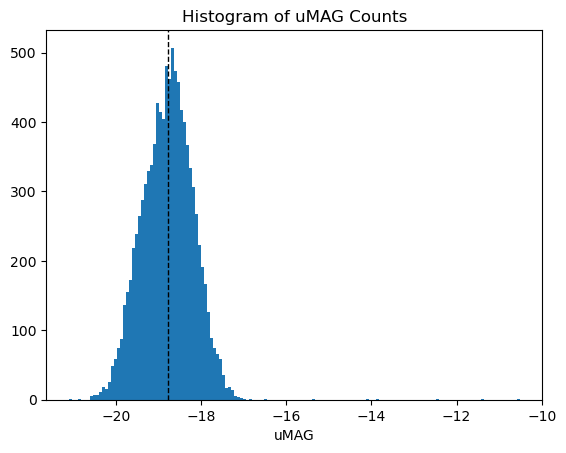

-19.560119999999998 -18.031591000000002


In [49]:

plt.hist(df['uMAG'], bins=150)
plt.axvline(df['uMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of uMAG Counts")
plt.xlabel("uMAG")
plt.show()
print(np.percentile(df['uMAG'],10),np.percentile(df['uMAG'],90)) # Find the censor range for later

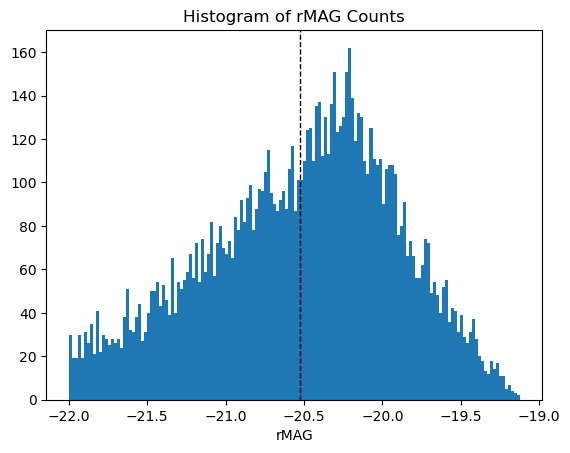

In [50]:
plt.hist(df['rMAG'], bins=150)
plt.axvline(df['rMAG'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Histogram of rMAG Counts")
plt.xlabel("rMAG")
plt.show()

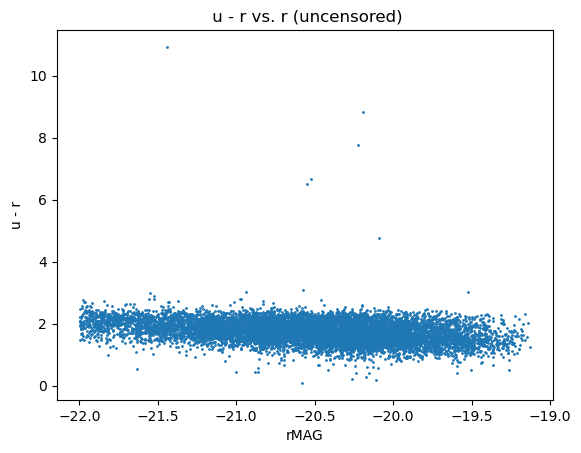

In [51]:
plt.scatter(df['rMAG'], df['u-r'],s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title(" u - r vs. r (uncensored)")
plt.show()

In [52]:
# Adding censored data column for -19.5 < uMAG < -18.1
print(len(df[df["uMAG"]>-18]))
df['censored_uMAG'] = df['uMAG'].clip(upper=-18,lower=-19.5) # Made the censoring code a little prettier
censored_array=np.array([])
for i in np.array(df["uMAG"]): # This code is ugly - does pandas have a way to do this itself?
    if (i<-18 and i>-19.5):
        censored_array=np.append(censored_array,False)
    else:
        censored_array=np.append(censored_array,True)
df['censored']=censored_array
df.head()
#df.loc[df['censored_uMAG'] > -17,'censored_uMAG'] = -17 (Old code)

895


,objID,z,uMAG,rMAG,u-r,SVMPython,censored_uMAG,censored
170027,1237654611217219807,0.064053,-19.16602,-20.46391,1.29789,1,-19.16602,0.0
253747,1237659132213264568,0.064192,-18.72878,-20.66912,1.94034,1,-18.72878,0.0
314099,1237653440839680162,0.056218,-18.33332,-19.58887,1.25555,1,-18.33332,0.0
14302,1237649963528749317,0.070524,-18.54039,-20.00025,1.45986,1,-18.54039,0.0
97180,1237667253469839537,0.065712,-19.66024,-21.76304,2.10280,1,-19.50000,1.0


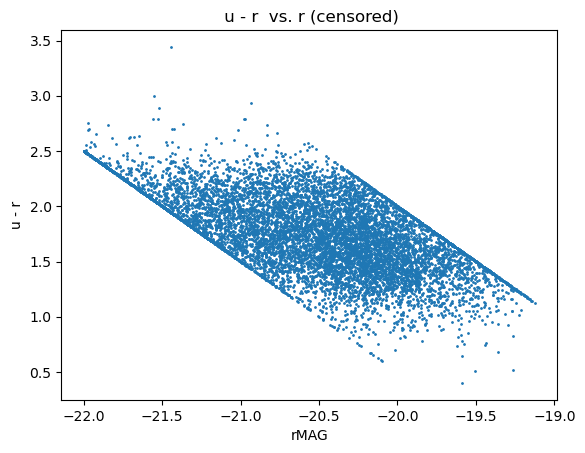

In [53]:
df['censored_u-r'] = df['censored_uMAG'] - df['rMAG']
plt.scatter(df['rMAG'], df['censored_u-r'], s=1)
plt.xlabel("rMAG")
plt.ylabel('u - r')
plt.title(" u - r  vs. r (censored)")
plt.show()

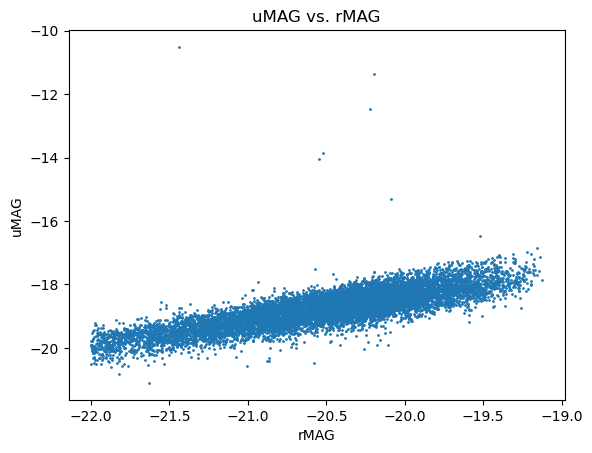

In [54]:
plt.scatter(df['rMAG'], df['uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('uMAG vs. rMAG')
plt.show()

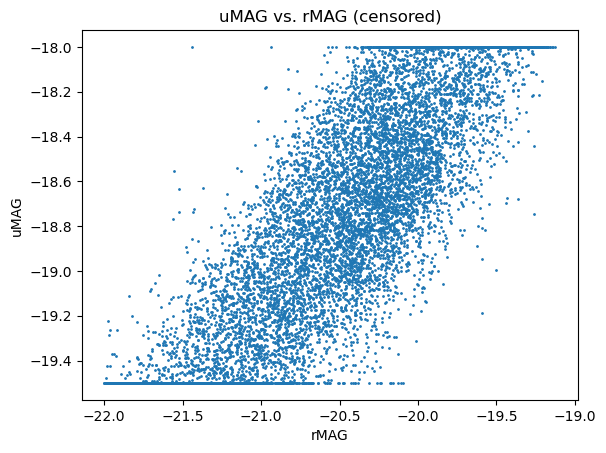

In [55]:
plt.scatter(df['rMAG'], df['censored_uMAG'], s=1)
plt.xlabel('rMAG')
plt.ylabel('uMAG')
plt.title('uMAG vs. rMAG (censored)')
plt.show()

# `u-r vs r (uncensored)`

In [12]:
def lregression(x, y):
    with pm.Model() as model:
        slope = pm.Normal("slope", mu=0, sigma=1)
        intercept = pm.Normal("intercept", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=1)
        y_likelihood = pm.Normal("y_likelihood", mu=slope * x + intercept, sigma=sigma, observed=y)

    return model

In [13]:
q1_model = lregression(df['rMAG'], df['uMAG'])

with q1_model:
    q1_fit = pm.sample(return_inferencedata=True, draws = 5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 46 seconds.


array([[<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

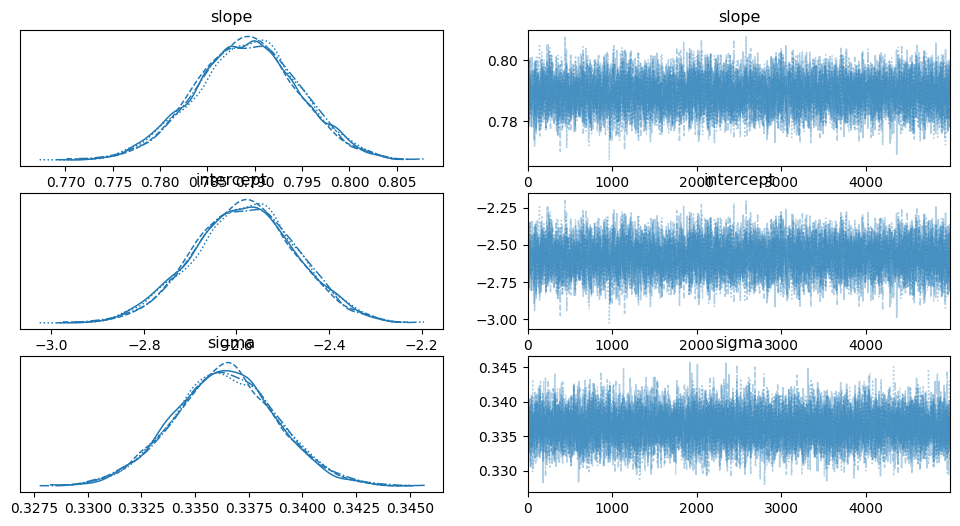

In [14]:
az.plot_trace(q1_fit)

In [15]:
summ=az.summary(q1_fit)
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,0.789,0.005,0.779,0.799,0.000,0.000,7189.0,7671.0,1.0
intercept,-2.582,0.111,-2.794,-2.376,0.001,0.001,7190.0,7719.0,1.0
sigma,0.336,0.002,0.332,0.341,0.000,0.000,9190.0,7533.0,1.0


[Text(0.5, 1.0, 'u-r vs r (uncensored data) fit'), None]

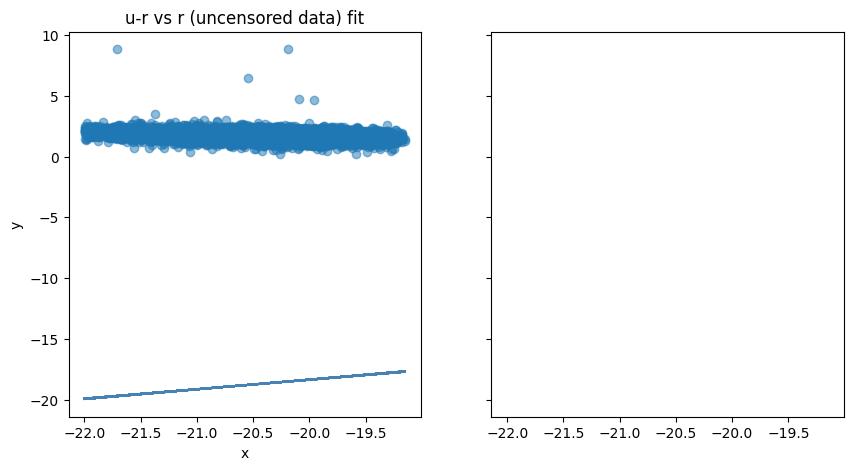

In [16]:
def pp_plot(xx, yy, fit, ax,true=True):
    # plot posterior predicted... samples from posterior
    xi = xr.DataArray(np.array([np.min(xx), np.max(xx)]), dims=["obs_id"])
    post = fit.posterior
    y_ppc = xi * post["slope"] + post["intercept"]
    ax.plot(xi, y_ppc.stack(sample=("chain", "draw")), c="steelblue", alpha=0.01, rasterized=True)
    ax.set(xlabel="x", ylabel="y")


fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].scatter(df['rMAG'], df['u-r'],alpha=0.5)
pp_plot(df['rMAG'], df['u-r'], q1_fit, ax[0],true=True)
ax[0].set(title="u-r vs r (uncensored data) fit",alpha=0.5)

# `u-r vs r (censored)`

In [58]:
df['uMAG'].describe()

count    10000.000000
mean       -18.777544
std          0.602581
min        -21.101660
25%        -19.190133
50%        -18.755225
75%        -18.372220
max        -10.514000
Name: uMAG, dtype: float64

In [56]:
def censored_regression(x, y):
    with pm.Model() as model:
        slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
        intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)
        sigma1 = pm.HalfNormal("sigma", sigma=1)
        y_latent = pm.Normal.dist(mu=slope1 * x + intercept1, sigma=sigma1)
        obs1 = pm.Censored("obs", y_latent, lower=-19.5, upper=-18, observed=y)

        start = pm.find_MAP()
        step = pm.NUTS()
    return model

In [57]:
censored_model = censored_regression(df['rMAG'], df['censored_uMAG'])

with censored_model:
    censored_fit = pm.sample(5000, init="adapt_diag", step=pm.NUTS())

C:\Users\wally\AppData\Local\Temp\ipykernel_13464\3966270151.py:3: FutureWarning: The `testval` argument is deprecated; use `initval`.
  slope1 = pm.Normal("slope", mu=0, tau=0.01, testval=0.0)
C:\Users\wally\AppData\Local\Temp\ipykernel_13464\3966270151.py:4: FutureWarning: The `testval` argument is deprecated; use `initval`.
  intercept1 = pm.Normal("intercept", mu=0, sigma=1, testval=0.0)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1665 seconds.


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

az.plot_posterior(censored_fit, var_names=["slope"], ref_val=slope, ax=ax[1])
ax[1].set(title="Censored regression\n(censored data)", xlabel="slope");

